# ImageCAS dataset EDA

## 1. Check data

In [1]:
import autorootcwd
import os
import nibabel as nib
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import glob
from tqdm import tqdm

In [2]:
base_path = "data/KU-PET-CT"

### Check data location and Count data

In [3]:
def check_missing_files(base_path):
    directories = [d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))]
    total_dirs = len(directories)
    
    print(f"\nTotal patient directory count: {total_dirs}")

    missing_patients = []
    
    for dir_name in tqdm(directories, desc="Checking missing files"):
        dir_path = os.path.join(base_path, dir_name)
        img_exists = os.path.exists(os.path.join(dir_path, 'CT.nii.gz'))
        label_exists = os.path.exists(os.path.join(dir_path, 'torso_fat.nii.gz'))
        
        if not (img_exists and label_exists):
            missing_files = []
            if not img_exists: missing_files.append('CT.nii.gz')
            if not label_exists: missing_files.append('torso_fat.nii.gz')
            missing_patients.append((dir_name, missing_files))
    
    if missing_patients:
        print("\nPatients with missing files:")
        for patient_id, missing_files in missing_patients:
            print(f"Patient {patient_id}: {', '.join(missing_files)} missing")
    else:
        print("\nAll patient data have img.nii.gz and label.nii.gz files.")

check_missing_files(base_path)


Total patient directory count: 147


Checking missing files: 100%|██████████| 147/147 [00:00<00:00, 16334.52it/s]


All patient data have img.nii.gz and label.nii.gz files.


### Get nifTi file metadata

In [4]:
data_path = "data/KU-PET-CT"
output_dir = "nbs/result/eda/"
os.makedirs(output_dir, exist_ok=True)

patient_folders = [os.path.basename(folder) for folder in glob.glob(os.path.join(data_path, "*"))]

output_file = os.path.join(output_dir, "KU-PET-CT_all_nifti_header_info.txt")

with open(output_file, 'w') as f:
    for patient_id in patient_folders:
        ct_file = os.path.join(data_path, patient_id, "CT.nii.gz")
        
        if os.path.exists(ct_file):
            nii = nib.load(ct_file)
            
            f.write(f"=== NIfTI Header Info [{patient_id}] ===\n\n")
            f.write(str(nii.header))
            f.write("\n\n=== Detailed Header Info ===\n\n")
            
            for field in nii.header:
                f.write(f"{field}: {nii.header[field]}\n")
            
            f.write("\n=== Additional Info ===\n")
            f.write(f"data type: {nii.get_data_dtype()}\n")
            f.write(f"image size: {nii.shape}\n")
            f.write(f"header size: {nii.header.sizeof_hdr} bytes\n")
            f.write("\n" + "="*50 + "\n\n")

print(f"header info is saved in {output_file}")

header info is saved in nbs/result/eda/KU-PET-CT_all_nifti_header_info.txt


### Check shape and voxel size of the image and label match

In [5]:
def check_match_img_and_label(base_path):
    results = []
    
    # Get all patient folders
    all_items = glob.glob(os.path.join(base_path, "*"))
    patient_folders = [os.path.basename(folder) for folder in all_items if os.path.isdir(folder)]
    
    for folder in tqdm(patient_folders):
        folder_path = os.path.join(base_path, folder)
        
        try:
            img_path = os.path.join(folder_path, 'CT.nii.gz')
            label_path = os.path.join(folder_path, 'torso_fat.nii.gz')
            
            # image file analysis
            if os.path.exists(img_path):
                img_nii = nib.load(img_path)
                img_shape = img_nii.shape
                img_voxel = img_nii.header.get_zooms()
            else:
                img_shape = None
                img_voxel = None
                
            # label file analysis
            if os.path.exists(label_path):
                label_nii = nib.load(label_path)
                label_shape = label_nii.shape
                label_voxel = label_nii.header.get_zooms()
            else:
                label_shape = None
                label_voxel = None
                
            results.append({
                'folder': folder,
                'img_shape': img_shape,
                'img_voxel_size': img_voxel,
                'label_shape': label_shape,
                'label_voxel_size': label_voxel
            })
            
        except Exception as e:
            print(f"[Error] Patient id {folder}: {str(e)}")
            
    return pd.DataFrame(results)

In [6]:
df = check_match_img_and_label(base_path)

df.to_csv('nbs/result/eda/KU-PET-CT_analysis_results.csv', index=False)

print("\n=== Analysis Results ===")
print("\nUnique image shape:")
print(df['img_shape'].value_counts())

print("\nUnique image voxel size:")
print(df['img_voxel_size'].value_counts())

mismatched_shape = df[df['img_shape'] != df['label_shape']]
if not mismatched_shape.empty:
    print("\nCases where image and label shape do not match:")
    print(mismatched_shape[['folder', 'img_shape', 'label_shape']])
else:
    print("\nAll image and label shapes match.")

mismatched_voxel = df[df['img_voxel_size'] != df['label_voxel_size']]
if not mismatched_voxel.empty:
    print("\nCases where image and label voxel size do not match:")
    print(mismatched_voxel[['folder', 'img_voxel_size', 'label_voxel_size']])
else:
    print("\nAll image and label voxel sizes match.")

# check missing files
missing = df[df['img_shape'].isna() | df['label_shape'].isna()]
if not missing.empty:
    print("\nFolders with missing files:")
    print(missing['folder'].tolist())

100%|██████████| 147/147 [00:00<00:00, 477.27it/s]


=== Analysis Results ===

Unique image shape:
img_shape
(512, 512, 341)    76
(512, 512, 395)    70
(512, 512, 287)     1
Name: count, dtype: int64

Unique image voxel size:
img_voxel_size
(0.976562, 0.976562, 2.79)    147
Name: count, dtype: int64

All image and label shapes match.

All image and label voxel sizes match.


### Check the voxel size and image shape for each data

In [7]:
def analyze_voxel_size_and_image_shape(base_path):
    results = []
    
    # Get all patient folders - only directories
    all_items = glob.glob(os.path.join(base_path, "*"))
    patient_folders = [folder for folder in all_items if os.path.isdir(folder)]
    
    for folder_path in tqdm(patient_folders):
        folder = os.path.basename(folder_path)
        img_path = os.path.join(folder_path, 'CT.nii.gz')
        
        if not os.path.exists(img_path):
            continue
            
        try:
            img_nii = nib.load(img_path)
            voxel_size = img_nii.header.get_zooms()
            shape = img_nii.shape
            
            results.append({
                'patient_id': folder,
                'voxel_x': voxel_size[0],
                'voxel_y': voxel_size[1],
                'voxel_z': voxel_size[2],
                'shape_x': shape[0],
                'shape_y': shape[1],
                'shape_z': shape[2]
            })
            
        except Exception as e:
            print(f"[Error] Patient id {folder}: {str(e)}")
    
    return pd.DataFrame(results)

Voxel Spacing

In [8]:
df = analyze_voxel_size_and_image_shape(base_path)

print("\n=== Voxel Size Statistics ===")
stats = df[['voxel_x', 'voxel_y', 'voxel_z']].describe()
print(stats)

# unique voxel size
unique_voxels = df.groupby(['voxel_x', 'voxel_y', 'voxel_z']).size().reset_index(name='count')
unique_voxels = unique_voxels.sort_values('count', ascending=False)
print("\n=== Unique Voxel Size Combination ===")
print(unique_voxels)

df.to_csv('nbs/result/eda/KU-PET-CT_voxel_size_comparison.csv', index=False)

# check outliers (cases more than 2 standard deviations from the mean)
print("\n=== Check Outliers ===")
for col in ['voxel_x', 'voxel_y', 'voxel_z']:
    mean = df[col].mean()
    std = df[col].std()
    outliers = df[abs(df[col] - mean) > 2*std]
    if not outliers.empty:
        print(f"\n{col} outliers:")
        print(outliers[['patient_id', col]])

100%|██████████| 147/147 [00:00<00:00, 1715.64it/s]


=== Voxel Size Statistics ===
          voxel_x     voxel_y  voxel_z
count  147.000000  147.000000   147.00
mean     0.976562    0.976562     2.79
std      0.000000    0.000000     0.00
min      0.976562    0.976562     2.79
25%      0.976562    0.976562     2.79
50%      0.976562    0.976562     2.79
75%      0.976562    0.976562     2.79
max      0.976562    0.976562     2.79

=== Unique Voxel Size Combination ===
    voxel_x   voxel_y  voxel_z  count
0  0.976562  0.976562     2.79    147

=== Check Outliers ===

voxel_x outliers:
    patient_id   voxel_x
0     00293921  0.976562
1     00343897  0.976562
2     00360064  0.976562
3     00470983  0.976562
4     00474639  0.976562
..         ...       ...
142   02427182  0.976562
143   02427183  0.976562
144   02429998  0.976562
145   02436495  0.976562
146   02438587  0.976562

[147 rows x 2 columns]

voxel_y outliers:
    patient_id   voxel_y
0     00293921  0.976562
1     00343897  0.976562
2     00360064  0.976562
3     00470983  0

Image Shape

In [9]:
df = analyze_voxel_size_and_image_shape(base_path)

print("\n=== Image Shape Statistics ===")
stats = df[['shape_x', 'shape_y', 'shape_z']].describe()
print(stats)

#unique image shape
unique_shapes = df.groupby(['shape_x', 'shape_y', 'shape_z']).size().reset_index(name='count')
unique_shapes = unique_shapes.sort_values('count', ascending=False)
print("\n=== Unique Image Shape Combination ===")
print(unique_shapes)

df.to_csv('nbs/result/eda/KU-PET-CT_image_shape_comparison.csv', index=False)

# check outliers (cases more than 2 standard deviations from the mean)
print("\n=== Check Outliers ===")
for col in ['shape_x', 'shape_y', 'shape_z']:
    mean = df[col].mean()
    std = df[col].std()
    outliers = df[abs(df[col] - mean) > 2*std]
    if not outliers.empty:
        print(f"\n{col} outliers:")
        print(outliers[['patient_id', col]])

100%|██████████| 147/147 [00:00<00:00, 1693.24it/s]


=== Image Shape Statistics ===
       shape_x  shape_y     shape_z
count    147.0    147.0  147.000000
mean     512.0    512.0  366.346939
std        0.0      0.0   27.770254
min      512.0    512.0  287.000000
25%      512.0    512.0  341.000000
50%      512.0    512.0  341.000000
75%      512.0    512.0  395.000000
max      512.0    512.0  395.000000

=== Unique Image Shape Combination ===
   shape_x  shape_y  shape_z  count
1      512      512      341     76
2      512      512      395     70
0      512      512      287      1

=== Check Outliers ===

shape_z outliers:
    patient_id  shape_z
101   02390383      287


### Check Intensity

In [12]:
def visualize_hu_distribution(base_path="data/KU-PET-CT", n_samples=10):
    cases = sorted(os.listdir(base_path))
    cases = [case for case in cases if os.path.isdir(os.path.join(base_path, case))]
    
    # random sampling
    random.seed(42)
    selected_cases = random.sample(cases, n_samples)
    
    all_intensities = []
    
    print(f"Analyzing {n_samples} random cases...")
    
    for case in tqdm(selected_cases, desc="Processing cases"):
        img_path = os.path.join(base_path, case, "CT.nii.gz")
        label_path = os.path.join(base_path, case, "vf.nii.gz")
        
        img_nifti = nib.load(img_path)
        label_nifti = nib.load(label_path)
        
        image = img_nifti.get_fdata()
        label = label_nifti.get_fdata()
        
        # coronary artery mask
        vessel_mask = label > 0
        vessel_intensities = image[vessel_mask]
        
        all_intensities.extend(vessel_intensities.flatten())
        
    mean_val = np.mean(all_intensities)
    std_val = np.std(all_intensities)
    median_val = np.median(all_intensities)

    plt.figure(figsize=(15, 6))
    
    n, bins, patches = plt.hist(all_intensities, 
                              bins=100,
                              density=True, 
                              alpha=0.3, 
                              color='r')
    
    plt.axvline(mean_val, color='b', linestyle='dashed', linewidth=2, label=f'Mean: {mean_val:.1f}')
    plt.axvline(median_val, color='g', linestyle='dashed', linewidth=2, label=f'Median: {median_val:.1f}')
    
    plt.xticks(np.arange(int(min(all_intensities)), int(max(all_intensities)), 50))  # 50 HU 
    plt.tick_params(axis='x', rotation=45)
    
    plt.grid(True, which='major', alpha=0.5, linestyle='-')
    plt.grid(True, which='minor', alpha=0.2, linestyle='--')
    
    plt.title(f'Distribution of HU Values in Coronary Arteries\n(from {n_samples} random cases)')
    plt.xlabel('HU Value')
    plt.ylabel('Density')
    plt.legend()
    
    plt.tight_layout()
    
    print("\nOverall Statistics:")
    print(f"Mean HU: {mean_val:.2f} ± {std_val:.2f}")
    print(f"Median HU: {median_val:.2f}")
    print(f"Range: [{min(all_intensities):.2f}, {max(all_intensities):.2f}]")
    print(f"Total voxels analyzed: {len(all_intensities)}")
    
    plt.show()
    
    return {
        'intensities': all_intensities,
        'mean': mean_val,
        'std': std_val,
        'median': median_val,
        'selected_cases': selected_cases
    }

Analyzing 100 random cases...


Processing cases: 100%|██████████| 100/100 [03:57<00:00,  2.38s/it]



Overall Statistics:
Mean HU: -98.77 ± 26.00
Median HU: -98.00
Range: [-1016.00, 384.00]
Total voxels analyzed: 105485287


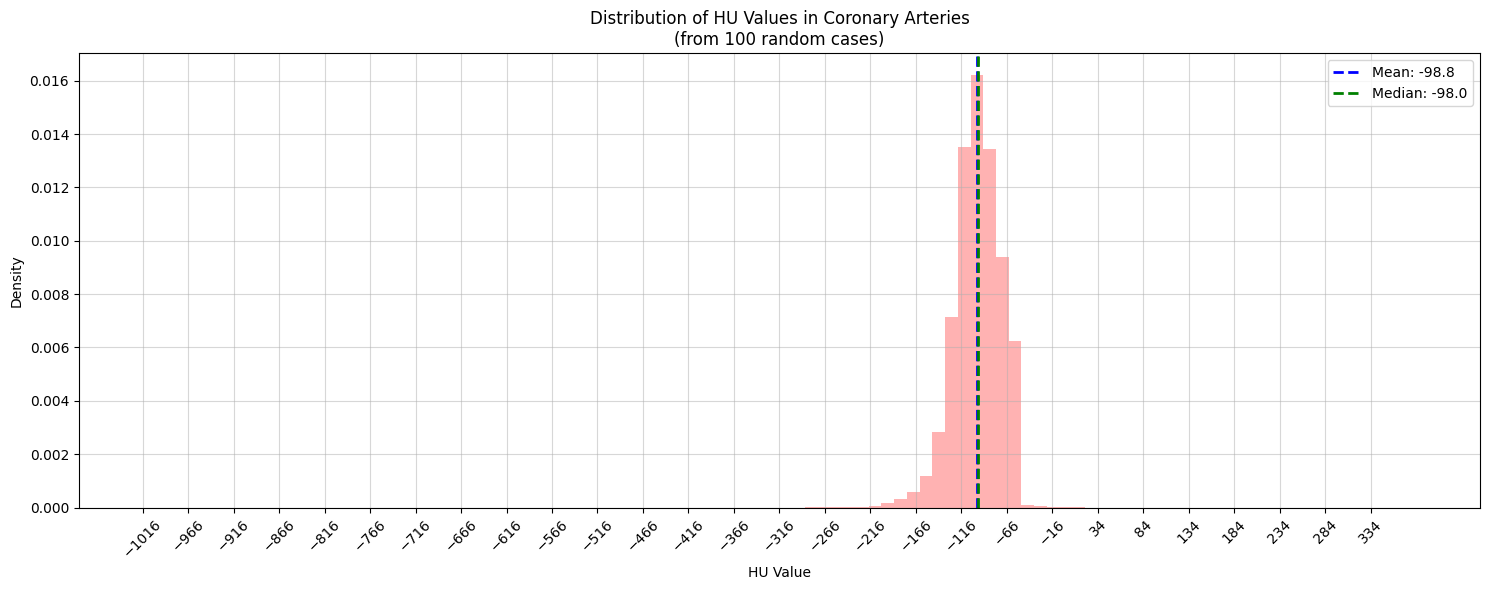

In [13]:
base_path = "data/KU-PET-CT"

results = visualize_hu_distribution(base_path, n_samples=100)

## Transforms in Dataloader

In [39]:
import autorootcwd
from monai.utils import first, set_determinism
from monai.transforms import (
    EnsureChannelFirstd,
    LoadImaged,
    Orientationd,
    ScaleIntensityRanged,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    RandFlipd,
    CropForegroundd,
    Compose,
    Spacingd,
    AsDiscreted,
    GaussianSmoothd,
    Lambda,
)
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
import SimpleITK as sitk
import os
import torch
import numpy as np
import pytorch_lightning as pl
from pathlib import Path
import matplotlib.pyplot as plt
import random
from scipy.ndimage import rotate

In [40]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        # Spacingd(
        #    keys=["image", "label"],
        #    pixdim=(1.5, 1.5, 2.0),
        #    mode=("bilinear", "nearest"),
        # ),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-200,
            a_max=100,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=6,
            image_key="image",
            image_threshold=0,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[0],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[1],
            prob=0.10,
        ),
        RandShiftIntensityd(keys="image", offsets=0.05, prob=0.5),
    ]
)

val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        # Spacingd(
        #    keys=["image", "label"],
        #    pixdim=(1.5, 1.5, 2.0),
        #    mode=("bilinear", "nearest"),
        # ),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-200,
            a_max=100,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
    ]
)

In [52]:
def visualize_transforms(image_path, label_path, slice_idx=80, transform=train_transforms):
    """visualize the before/after transforms for a specific image."""
    
    data_dict = [{"image": image_path, "label": label_path}]
    
    basic_transforms = Compose([
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
    ])
    
    basic_ds = Dataset(data=data_dict, transform=basic_transforms)
    full_ds = Dataset(data=data_dict, transform=transform)
    
    basic_data = first(DataLoader(basic_ds, batch_size=1))
    full_data = first(DataLoader(full_ds, batch_size=1))
    
    plt.figure("Transforms Visualization", (15, 10))
    
    aspect_ratio = 2.79 / 0.98 
    
    # Original Image
    plt.subplot(2, 2, 1)
    plt.title("Original Image")
    orig_img = basic_data["image"][0, 0, :, slice_idx, :]
    plt.imshow(rotate(orig_img, 90), cmap="gray", aspect=aspect_ratio)
    
    # Original Label
    plt.subplot(2, 2, 2)
    plt.title("Original Label")
    orig_lb = basic_data["label"][0, 0, :, slice_idx, :]
    plt.imshow(rotate(orig_lb, 90), aspect=aspect_ratio)
    
    # Transformed Image
    plt.subplot(2, 2, 3)
    plt.title("Transformed Image")
    trans_img = full_data["image"][0, 0, :, slice_idx, :]
    plt.imshow(rotate(trans_img, 90), cmap="gray", aspect=aspect_ratio)
    
    # Transformed Label
    plt.subplot(2, 2, 4)
    plt.title("Transformed Label")
    trans_lb = full_data["label"][0, 0, :, slice_idx, :]
    plt.imshow(rotate(trans_lb, 90), aspect=aspect_ratio)
    
    plt.tight_layout()
    plt.show()
    
    print("Original Image shape:", basic_data["image"].shape)
    print("Original Image value range:", 
          basic_data["image"].min().item(), "to", 
          basic_data["image"].max().item())
    
    print("\nTransformed Image shape:", full_data["image"].shape)
    print("Transformed Image value range:", 
          full_data["image"].min().item(), "to", 
          full_data["image"].max().item())


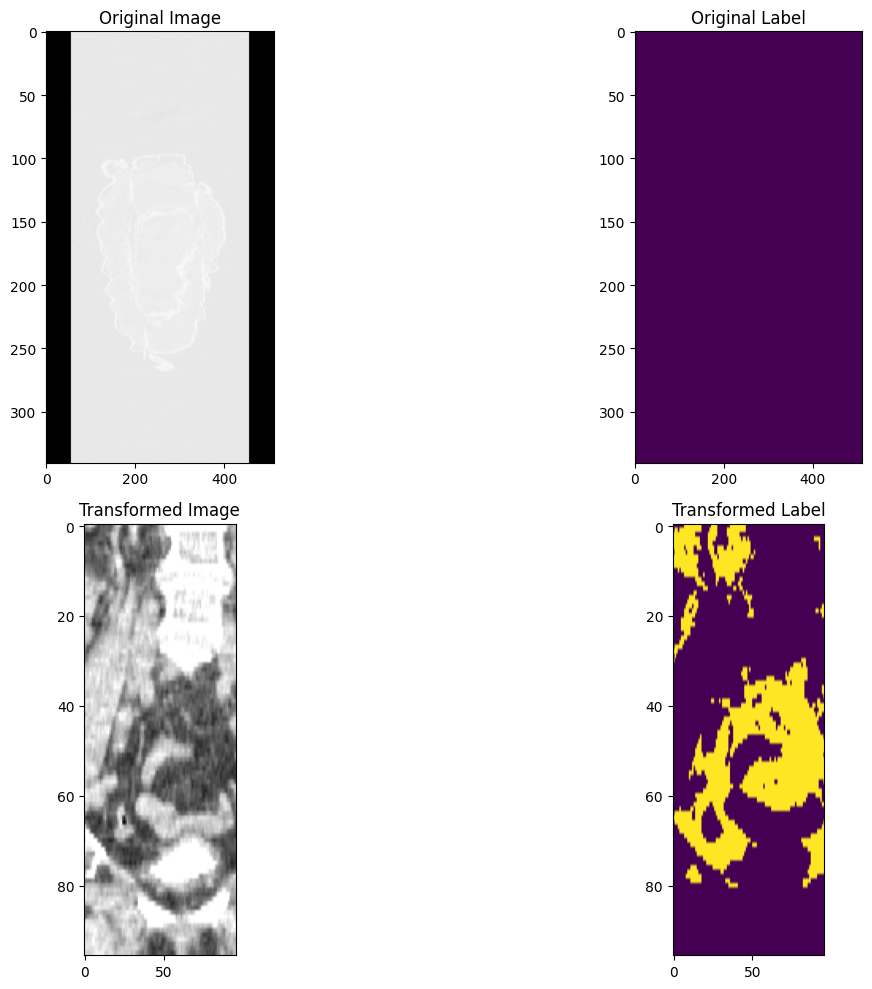

Original Image shape: torch.Size([1, 1, 512, 512, 341])
Original Image value range: -3024.0 to 3071.0

Transformed Image shape: torch.Size([6, 1, 96, 96, 96])
Transformed Image value range: -0.016291284933686256 to 1.0470210313796997


In [55]:
case_dir = "data/KU-PET-CT/00293921"
image_path = os.path.join(case_dir, "CT.nii.gz")
label_path = os.path.join(case_dir, "vf.nii.gz")

visualize_transforms(image_path, label_path, slice_idx=95, transform=train_transforms)

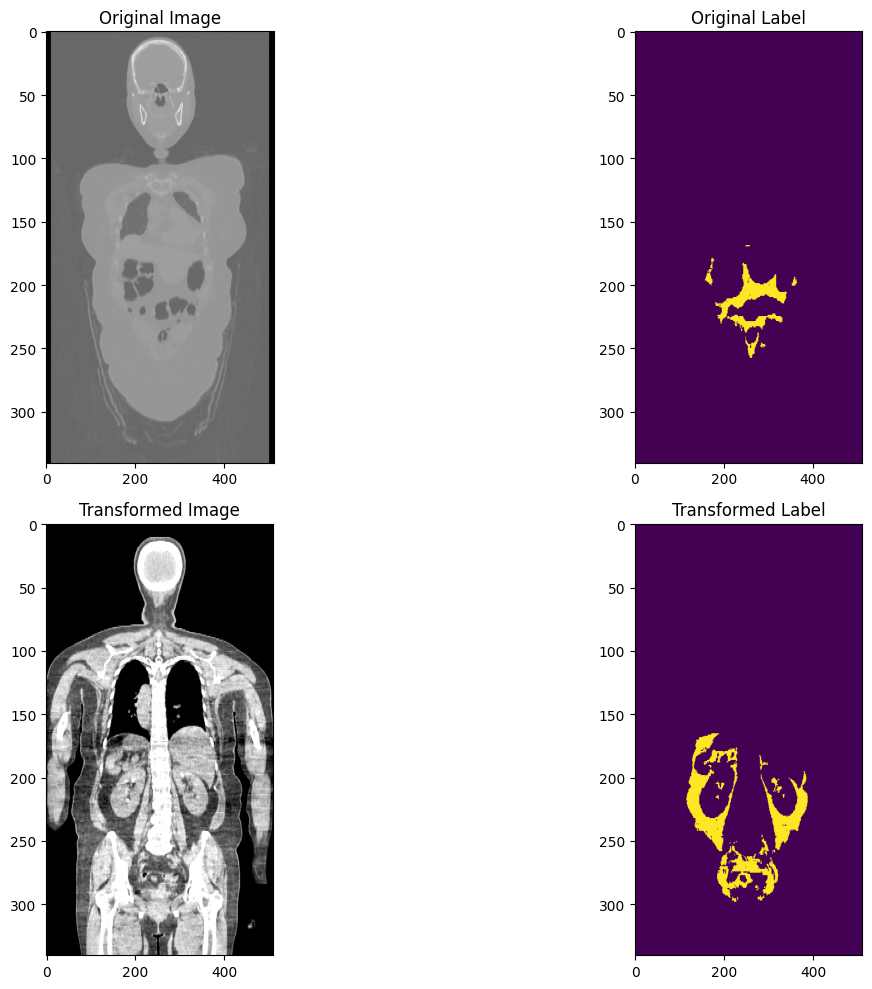

Original Image shape: torch.Size([1, 1, 512, 512, 341])
Original Image value range: -3024.0 to 3071.0

Transformed Image shape: torch.Size([1, 1, 511, 357, 341])
Transformed Image value range: 0.0 to 1.0


In [53]:
case_dir = "data/KU-PET-CT/00293921"
image_path = os.path.join(case_dir, "CT.nii.gz")
label_path = os.path.join(case_dir, "vf.nii.gz")

visualize_transforms(image_path, label_path, slice_idx=180, transform=val_transforms)

## Transforms in Proposed Dataloader

In [56]:
use_distance_map = True
random.seed(42)

In [57]:
def create_distance_map(binary_mask):
    distance_maps = []
    
    for c in range(binary_mask.shape[0]):  # each channel
        channel_mask = binary_mask[c].numpy()  # [H, W, D]
        
        # convert to SimpleITK image
        sitk_mask = sitk.GetImageFromArray(channel_mask)
        sitk_mask = sitk.Cast(sitk_mask, sitk.sitkUInt8)
        
        # create distance map
        distance_map = sitk.SignedMaurerDistanceMap(
            sitk_mask,
            insideIsPositive=False,  # heart outside is positive
            squaredDistance=False,
            useImageSpacing=True     # physical distance (mm)
        )
        
        # convert to tensor
        distance_map_array = sitk.GetArrayFromImage(distance_map)
        distance_maps.append(torch.from_numpy(distance_map_array))
    
    return torch.stack(distance_maps)

def convertDistanceMap(data):
    seg = data["seg"]  # [C, H, W, D] one-hot encoded segmentation
    
    distance_map = create_distance_map(seg)
    
    data["seg"] = distance_map
    return data


In [58]:
transforms = [
    LoadImaged(keys=["image", "label", "seg"]),
    EnsureChannelFirstd(keys=["image", "label", "seg"]),
    Orientationd(keys=["image", "label", "seg"], axcodes="RAS"),
    ScaleIntensityRanged(
        keys=["image"],
        a_min=-200,
        a_max=100,
        b_min=0.0,
        b_max=1.0,
        clip=True,
    ),
    AsDiscreted(
        keys=["seg"],
        to_onehot=8,
    ),
    CropForegroundd(keys=["image", "label", "seg"], source_key="image"),
]

# distance map 
if use_distance_map:
    transforms.append(Lambda(convertDistanceMap))

transforms.extend([
    RandCropByPosNegLabeld(
        keys=["image", "label", "seg"],
        label_key="label",
        spatial_size=(96, 96, 96),
        pos=1,
        neg=1,
        num_samples=4,
        image_key="image",
        image_threshold=0,
    ),
    RandFlipd(
        keys=["image", "label", "seg"],
        spatial_axis=[0],
        prob=0.10,
    ),
    RandFlipd(
        keys=["image", "label", "seg"],
        spatial_axis=[1],
        prob=0.10,
    ),
])

if not use_distance_map:
    transforms.append(GaussianSmoothd(keys=["seg"], sigma=1.0))

transforms.append(RandShiftIntensityd(keys="image", offsets=0.05, prob=0.5))

val_transforms = [
    LoadImaged(keys=["image", "label", "seg"]),
    EnsureChannelFirstd(keys=["image", "label", "seg"]),
    Orientationd(keys=["image", "label", "seg"], axcodes="RAS"),
    ScaleIntensityRanged(
        keys=["image"],
        a_min=-200,
        a_max=100,
        b_min=0.0,
        b_max=1.0,
        clip=True,
    ),
    AsDiscreted(
        keys=["seg"],
        to_onehot=8,
    ),
    CropForegroundd(keys=["image", "label", "seg"], source_key="image"),
]

# distance map
if use_distance_map:
    val_transforms.append(Lambda(convertDistanceMap))

if not use_distance_map:
    val_transforms.append(GaussianSmoothd(keys=["seg"], sigma=1.0))

val_transforms = Compose(val_transforms)

train_transforms = Compose(transforms)
val_transforms = Compose(val_transforms)

c:\SEOA\virtual\viceral-fat\.venv\lib\site-packages\monai\utils\deprecate_utils.py:321: FutureWarning: monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.
  warn_deprecated(argname, msg, warning_category)


In [59]:
def visualize_transforms(image_path, label_path, seg_path, slice_idx=80, transform=train_transforms):
    """visualize the before/after transforms for a specific image."""
    
    data_dict = [{"image": image_path, "label": label_path, "seg": seg_path}]
    
    basic_transforms = Compose([
        LoadImaged(keys=["image", "label", "seg"]),
        EnsureChannelFirstd(keys=["image", "label", "seg"]),
    ])
    
    basic_ds = Dataset(data=data_dict, transform=basic_transforms)
    full_ds = Dataset(data=data_dict, transform=transform)
    
    basic_data = first(DataLoader(basic_ds, batch_size=1))
    full_data = first(DataLoader(full_ds, batch_size=1))
    
    plt.figure("Transforms Visualization", (15, 10))

    aspect_ratio = 2.79 / 0.98
    
    # Original Data (First Row)
    plt.subplot(2, 3, 1)
    plt.title("Original Image")
    orig_img = basic_data["image"][0, 0, :, slice_idx, :]
    plt.imshow(rotate(orig_img, 90), cmap="gray", aspect=aspect_ratio)
    
    plt.subplot(2, 3, 2)
    plt.title("Original Label")
    plt.imshow(basic_data["label"][0, 0, :, :, slice_idx])

    plt.subplot(2, 3, 3)
    plt.title("Original Segmentation")
    plt.imshow(basic_data["seg"][0, 0, :, :, slice_idx])
    
    # Transformed Data (Second Row)
    plt.subplot(2, 3, 4)
    plt.title("Transformed Image")
    plt.imshow(full_data["image"][0, 0, :, :, slice_idx], cmap="gray")
    
    plt.subplot(2, 3, 5)
    plt.title("Transformed Label")
    plt.imshow(full_data["label"][0, 0, :, :, slice_idx])

    plt.subplot(2, 3, 6)
    plt.title("Transformed Segmentation")
    plt.imshow(full_data["seg"][0, 0, :, :, slice_idx])
    # if full_data["seg"].shape[1] > 1:  # if one-hot encoded or distance map
    #     # Combine all channels for visualization
    #     seg_vis = np.sum(full_data["seg"][0, :, :, :, slice_idx], axis=0)
    #     plt.imshow(seg_vis)
    # else:
    #     plt.imshow(full_data["seg"][0, 0, :, :, slice_idx])
    
    plt.tight_layout()
    plt.show()
   

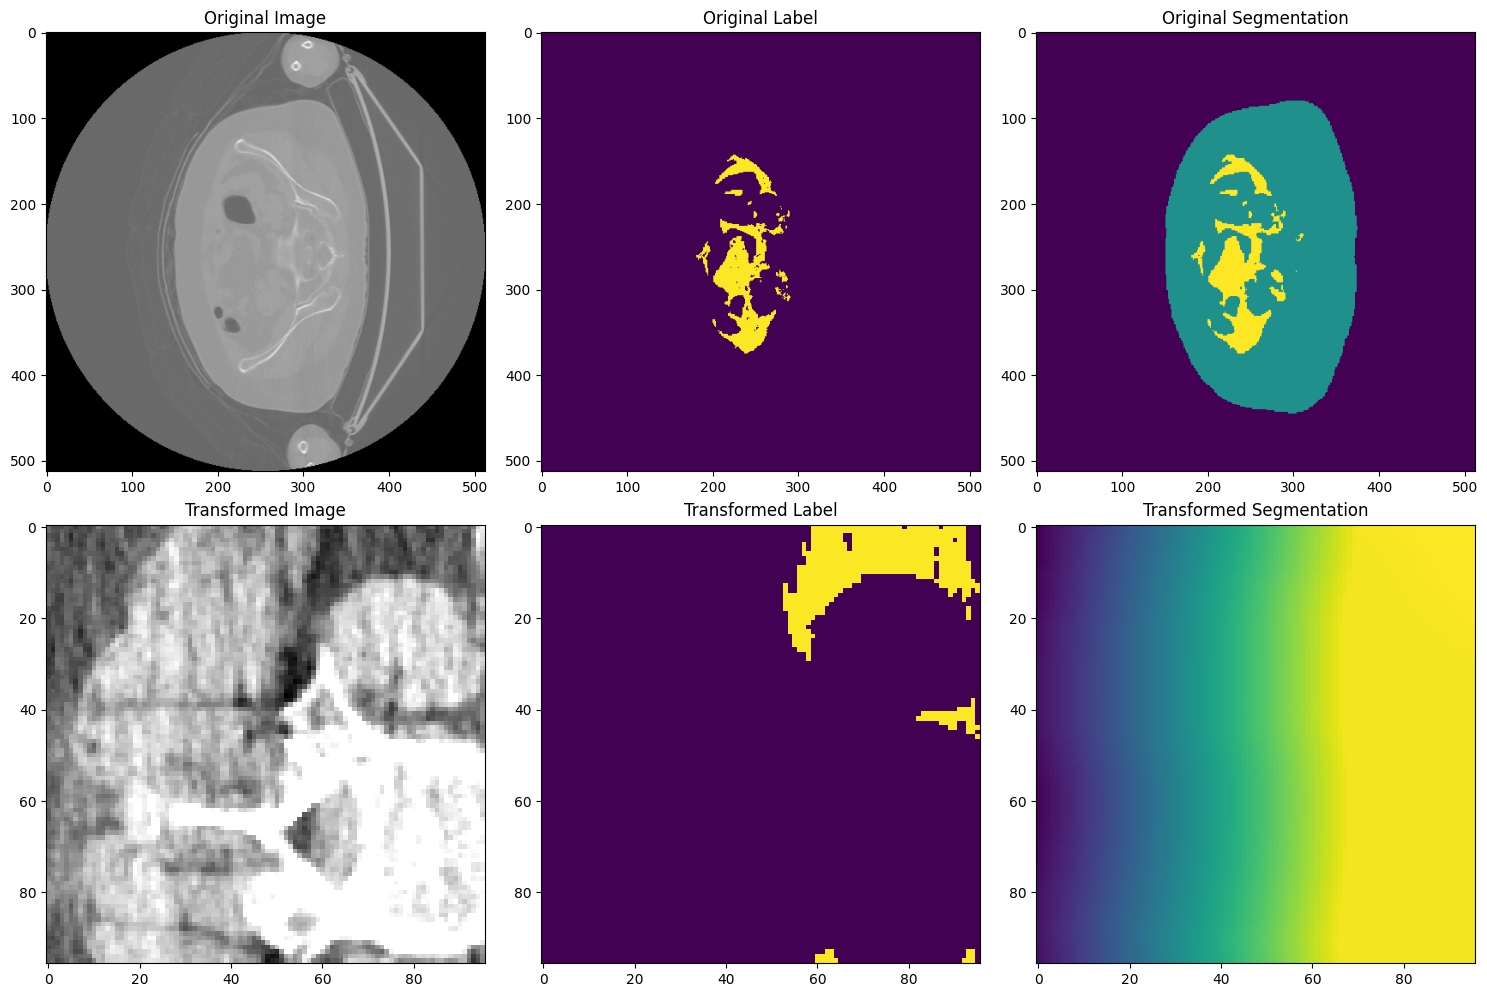

In [60]:
case_dir = "data/KU-PET-CT/00293921"
image_path = os.path.join(case_dir, "CT.nii.gz")
label_path = os.path.join(case_dir, "vf.nii.gz")
seg_path = os.path.join(case_dir, "combined_seg.nii.gz")

visualize_transforms(image_path, label_path, seg_path, slice_idx=80, transform=train_transforms)

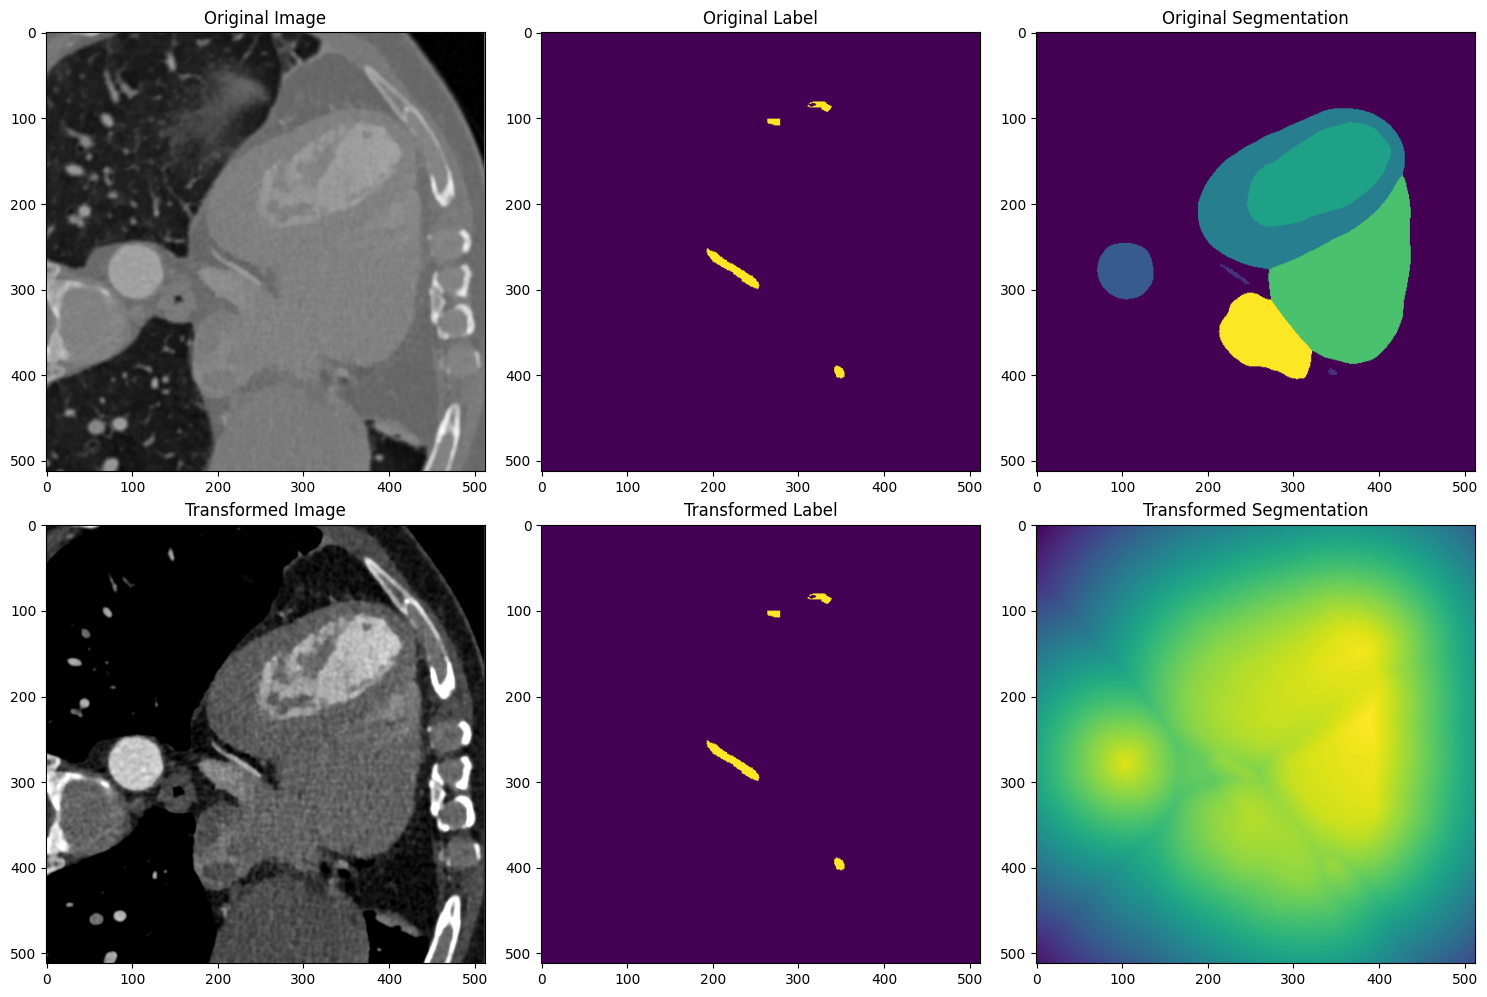

In [56]:
case_dir = "data/KU-PET-CT/00293921"
image_path = os.path.join(case_dir, "CT.nii.gz")
label_path = os.path.join(case_dir, "vf.nii.gz")
seg_path = os.path.join(case_dir, "combined_seg.nii.gz")

visualize_transforms(image_path, label_path, seg_path, slice_idx=80, transform=val_transforms)

## Transforms in Proposed Dataloader with MONAI

In [104]:
import autorootcwd
import monai
from monai.utils import first, set_determinism
from monai.transforms import (
    EnsureChannelFirstd,
    LoadImaged,
    Orientationd,
    ScaleIntensityRanged,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    RandFlipd,
    CropForegroundd,
    Compose,
    Spacingd,
    AsDiscreted,
    GaussianSmoothd,
    Lambda,
    DistanceTransformEDTd, DistanceTransformEDT,
    ToTensord,
)
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
import SimpleITK as sitk
import os
import torch
import numpy as np
import pytorch_lightning as pl
from pathlib import Path
import matplotlib.pyplot as plt
import cucim

print(cucim.__version__)
from monai.transforms import DistanceTransformEDTd
print(DistanceTransformEDTd.__module__)
print(DistanceTransformEDTd.__doc__)

23.10.00
monai.transforms.post.dictionary

    Applies the Euclidean distance transform on the input.
    Either GPU based with CuPy / cuCIM or CPU based with scipy.
    To use the GPU implementation, make sure cuCIM is available and that the data is a `torch.tensor` on a GPU device.

    Note that the results of the libraries can differ, so stick to one if possible.
    For details, check out the `SciPy`_ and `cuCIM`_ documentation and / or :func:`monai.transforms.utils.distance_transform_edt`.


    Note on the input shape:
        Has to be a channel first array, must have shape: (num_channels, H, W [,D]).
        Can be of any type but will be converted into binary: 1 wherever image equates to True, 0 elsewhere.
        Input gets passed channel-wise to the distance-transform, thus results from this function will differ
        from directly calling ``distance_transform_edt()`` in CuPy or SciPy.

    Args:
        keys: keys of the corresponding items to be transformed.
        all

In [106]:
use_distance_map = True

In [ ]:
transforms = [
    LoadImaged(keys=["image", "label", "seg"]),
    EnsureChannelFirstd(keys=["image", "label", "seg"]),
    Orientationd(keys=["image", "label", "seg"], axcodes="RAS"),
    ScaleIntensityRanged(
        keys=["image"],
        a_min=-200,
        a_max=100,
        b_min=0.0,
        b_max=1.0,
        clip=True,
    ),
    AsDiscreted(
        keys=["seg"],
        to_onehot=8,
    ),
    CropForegroundd(keys=["image", "label", "seg"], source_key="image"),
]

# distance map 
if use_distance_map:
    transforms.append(
        DistanceTransformEDTd(keys=["seg"])
    )

transforms.extend([
    RandCropByPosNegLabeld(
        keys=["image", "label", "seg"],
        label_key="label",
        spatial_size=(96, 96, 96),
        pos=1,
        neg=1,
        num_samples=4,
        image_key="image",
        image_threshold=0,
    ),
    RandFlipd(
        keys=["image", "label", "seg"],
        spatial_axis=[0],
        prob=0.10,
    ),
    RandFlipd(
        keys=["image", "label", "seg"],
        spatial_axis=[1],
        prob=0.10,
    ),
])

if not use_distance_map:
    transforms.append(GaussianSmoothd(keys=["seg"], sigma=1.0))

transforms.append(RandShiftIntensityd(keys="image", offsets=0.05, prob=0.5))

val_transforms = [
    LoadImaged(keys=["image", "label", "seg"]),
    EnsureChannelFirstd(keys=["image", "label", "seg"]),
    Orientationd(keys=["image", "label", "seg"], axcodes="RAS"),
    ScaleIntensityRanged(
        keys=["image"],
        a_min=-200,
        a_max=100,
        b_min=0.0,
        b_max=1.0,
        clip=True,
    ),
    AsDiscreted(
        keys=["seg"],
        to_onehot=8,
    ),
    CropForegroundd(keys=["image", "label", "seg"], source_key="image"),
]

# distance map
if use_distance_map:
    val_transforms.append(DistanceTransformEDTd(keys=["seg"]))

if not use_distance_map:
    val_transforms.append(GaussianSmoothd(keys=["seg"], sigma=1.0))

val_transforms = Compose(val_transforms)

train_transforms = Compose(transforms)
val_transforms = Compose(val_transforms)

In [66]:
def visualize_transforms(image_path, label_path, seg_path, slice_idx=80, transform=train_transforms):
    """visualize the before/after transforms for a specific image."""
    
    data_dict = [{"image": image_path, "label": label_path, "seg": seg_path}]
    
    basic_transforms = Compose([
        LoadImaged(keys=["image", "label", "seg"]),
        EnsureChannelFirstd(keys=["image", "label", "seg"]),
    ])
    
    basic_ds = Dataset(data=data_dict, transform=basic_transforms)
    full_ds = Dataset(data=data_dict, transform=transform)
    
    basic_data = first(DataLoader(basic_ds, batch_size=1))
    full_data = first(DataLoader(full_ds, batch_size=1))
    
    print("Transformed seg device:", full_data["seg"].device)
    print("Transformed image device:", full_data["image"].device)
    
    plt.figure("Transforms Visualization", (15, 10))
    
    # Original Data (First Row)
    plt.subplot(2, 3, 1)
    plt.title("Original Image")
    plt.imshow(basic_data["image"][0, 0, :, :, slice_idx], cmap="gray")
    
    plt.subplot(2, 3, 2)
    plt.title("Original Label")
    plt.imshow(basic_data["label"][0, 0, :, :, slice_idx])

    plt.subplot(2, 3, 3)
    plt.title("Original Segmentation")
    plt.imshow(basic_data["seg"][0, 0, :, :, slice_idx])
    
    # Transformed Data (Second Row)
    plt.subplot(2, 3, 4)
    plt.title("Transformed Image")
    plt.imshow(full_data["image"][0, 0, :, :, slice_idx], cmap="gray")
    
    plt.subplot(2, 3, 5)
    plt.title("Transformed Label")
    plt.imshow(full_data["label"][0, 0, :, :, slice_idx])

    plt.subplot(2, 3, 6)
    plt.title("Transformed Segmentation")
    plt.imshow(full_data["seg"][0, 0, :, :, slice_idx].cpu())
    # if full_data["seg"].shape[1] > 1:  # if one-hot encoded or distance map
    #     # Combine all channels for visualization
    #     seg_vis = np.sum(full_data["seg"][0, :, :, :, slice_idx], axis=0)
    #     plt.imshow(seg_vis)
    # else:
    #     plt.imshow(full_data["seg"][0, 0, :, :, slice_idx])
    
    plt.tight_layout()
    plt.show()
   

Transformed seg device: cuda:0
Transformed image device: cpu


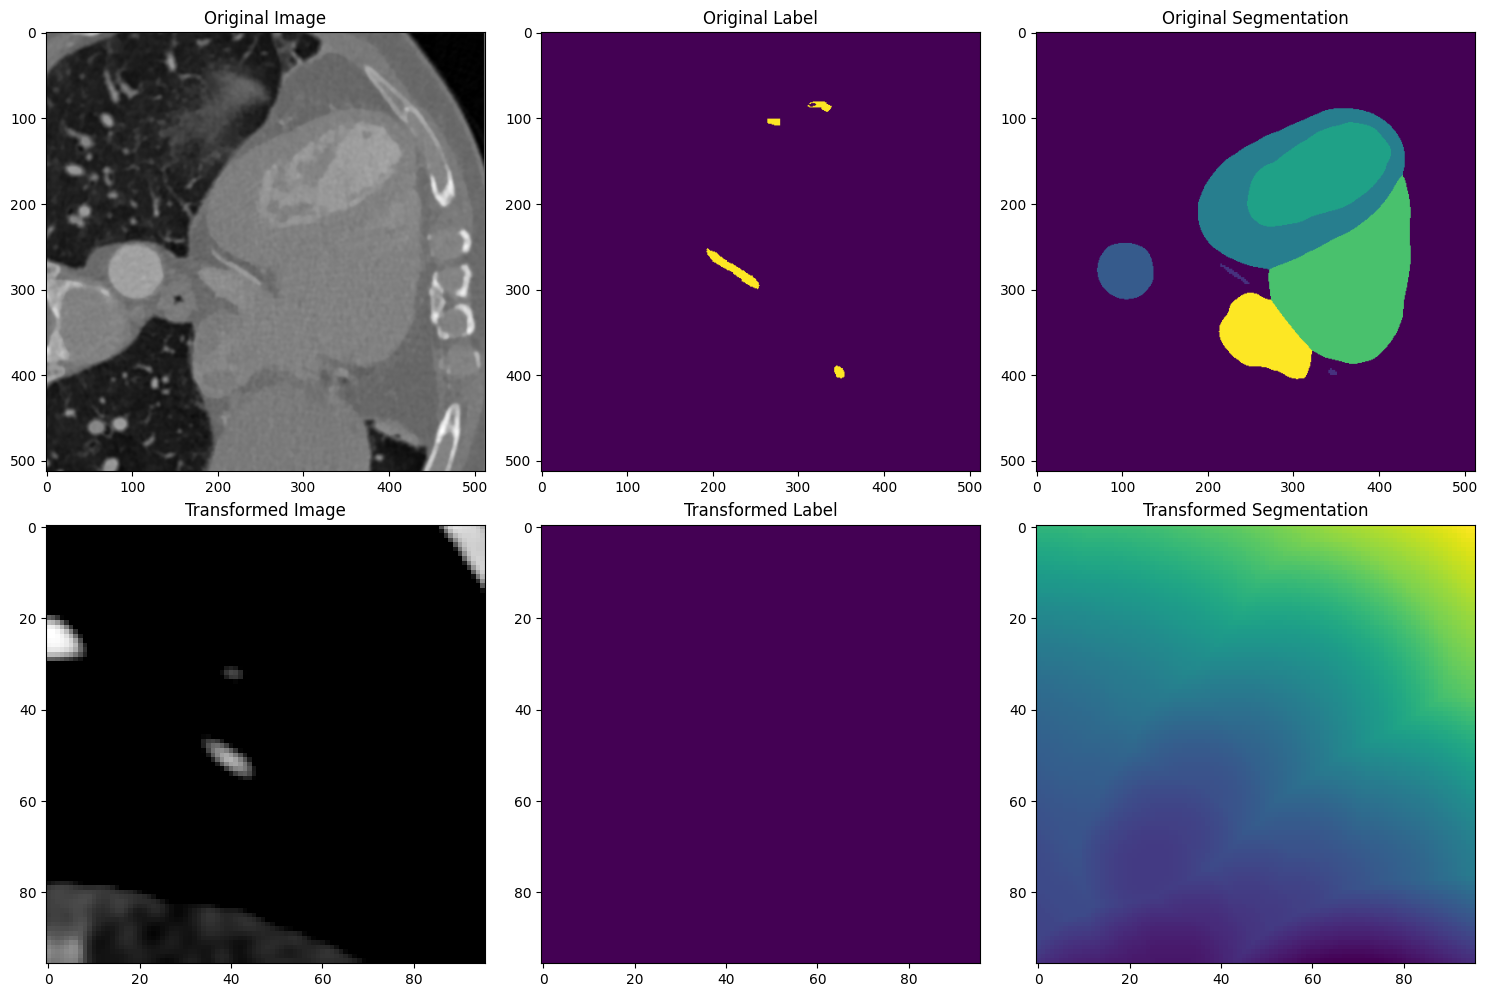

In [67]:
case_dir = "data/KU-PET-CT/00293921"
image_path = os.path.join(case_dir, "CT.nii.gz")
label_path = os.path.join(case_dir, "vf.nii.gz")
seg_path = os.path.join(case_dir, "combined_seg.nii.gz")

visualize_transforms(image_path, label_path, seg_path, slice_idx=80, transform=train_transforms)

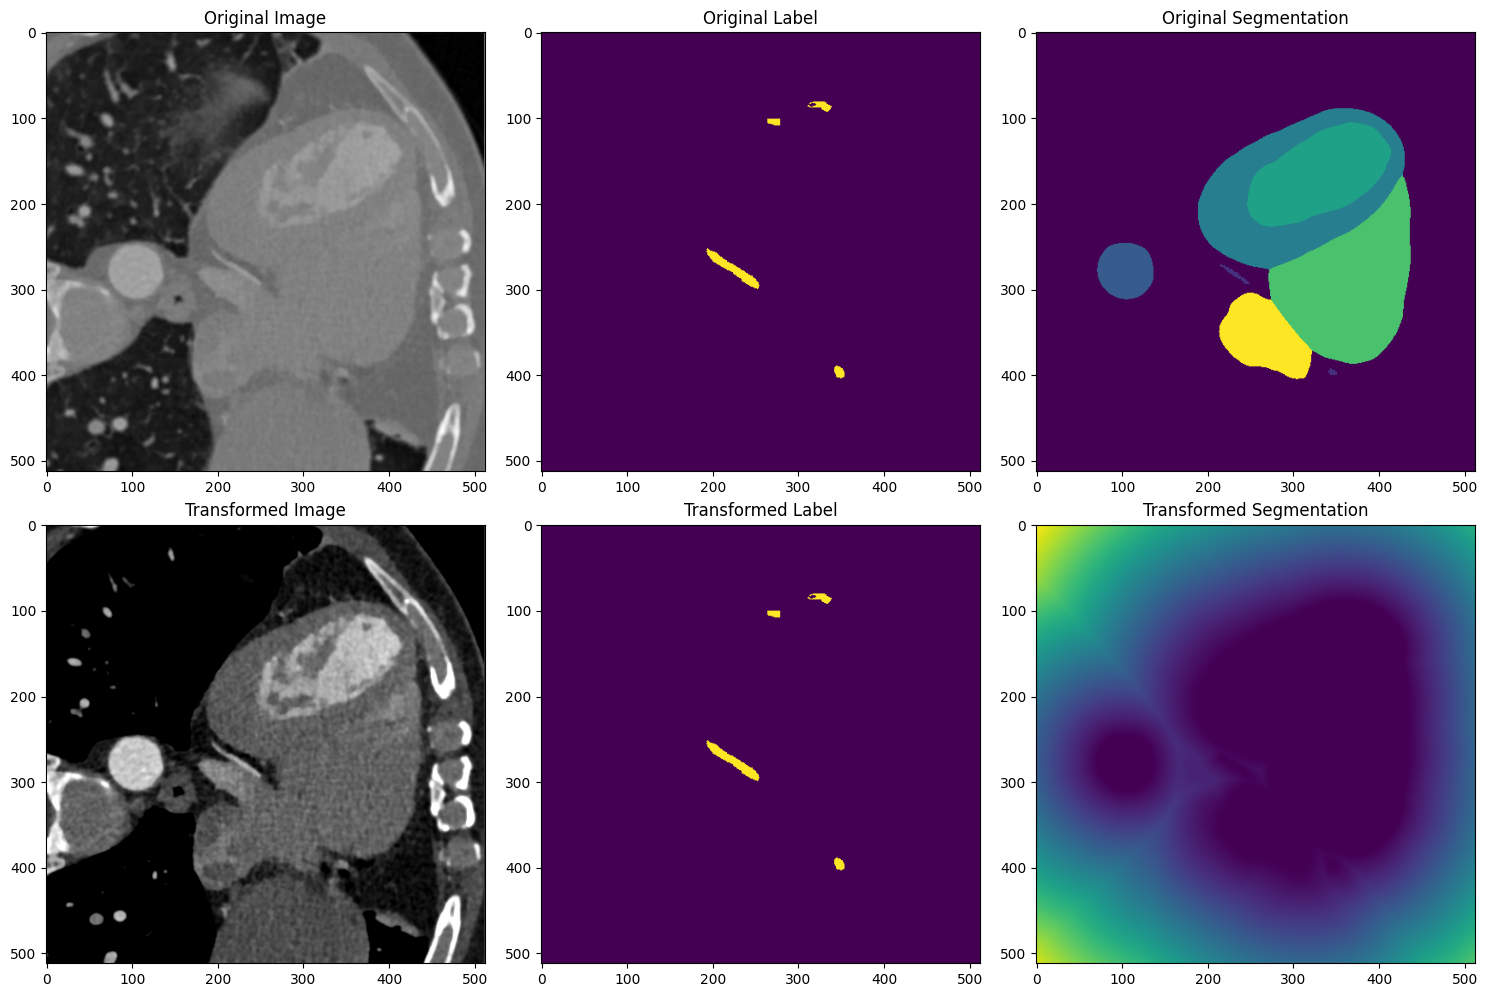

In [24]:
case_dir = "data/KU-PET-CT/00293921"
image_path = os.path.join(case_dir, "CT.nii.gz")
label_path = os.path.join(case_dir, "vf.nii.gz")
seg_path = os.path.join(case_dir, "combined_seg.nii.gz")

visualize_transforms(image_path, label_path, seg_path, slice_idx=80, transform=val_transforms)

In [71]:
import time
import torch

# 예시: [C, H, W, D] shape의 one-hot mask
mask = torch.randint(0, 2, (8, 256, 256, 256)).float()

from monai.transforms import DistanceTransformEDT

distance_transform = DistanceTransformEDT()

# CPU에서 시간 측정
start = time.time()
result_cpu = distance_transform(mask)
print("CPU time:", time.time() - start)

# GPU에서 시간 측정
mask_cuda = mask.cuda()
torch.cuda.synchronize()
start = time.time()
result_gpu = distance_transform(mask_cuda)
torch.cuda.synchronize()
print("GPU time:", time.time() - start)

CPU time: 28.43778085708618
GPU time: 28.320678234100342
